In [9]:
format compact
addpath('/Users/alfordb/Documents/MATLAB/code')


# Magnus Expansion Tools - Project Log
## Ben Alford  -  Dartmouth College  -  December 2020

The objective of this project was to write code to calculate the size of the first few terms of the Magnus expansion for different pulse sequences and different values of the system parameters.  The main sequences considered were WHH-4 and MREV-8.  This tool can be used to determine the magnus expansion terms for any arbitrary pulse sequence, though the computation time grows rapidly for longer sequences.  The parameters considered were the delay spacing in between pulses (tau), the strength of the dipole hamiltonian (coupling) and the strength of the offset hamiltonian (Delta) which combines the resonance offset and chemical shift of the system.

The formula currently in use for the size $h_n$ of a term $H^{(n)}$ in the expansion is: $$h_n=\log_{10}\Big(\sqrt{\text{Tr}\big(H^{(n)}.H^{(n)}\big)}\Big)$$ 
and is calculated using the function below (this code will not run in Jupyter but is displayed here)

In [53]:
function orh = matOrder(A) % calculates the magnitude of a matrix
    orh = log10(sqrt(trace(A*A)));
end

Error: Function definition not supported in this context. Create functions in code file.


Existing code from the Spin Simulation script is used construct the spin operators and set the initial parameters.

In [10]:

N = 4;
dim = 2^N;
Ncyc = 1;
pulse = 0;
tau = 3e-6;  % delay spacing
coupling = 5000;
f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
w1 = 2*pi*f1;
Delta = 500;

% initvars
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


%initCollectiveObs;
Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);
for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end


I likewise used existing code to generate the dipole hamiltonian.  I generated a set of 8 to use (changeable using the variable **couplingsCount**) based on random coupling matrices.

In [4]:
couplingsCount = 8;
Hdips = cell(couplingsCount,1);
% Generate 8 dipole Hamiltonians, each with a different coupling matrix
for j=1:couplingsCount
    dip = abs(randn(N));
    dip = triu(dip,1) + triu(dip,1)';
    Hdips{j} = getHdip(N, dim, x, y, z, dip);
end

A pulse sequence must then be chosen.  If the sequence is already in the script, then its name can be entered into the variable **sequenceName**. A set of if/else statements using **strcmp** will later select the proper set of pulses and delays.

In [5]:
sequenceName = 'WHH';
% sequenceName = 'MREV8';
% sequenceName = 'CORY48';

Pulse sequences are entered into the script as a pair of arrays.  The first array, **Pulses**, is a Cell array consisting of the pulse sequence.  The second array, **Taus**, is a regular list array consisting of the spacing that precedes each pulse in the Cell array.  The length of the second array should always be one entry longer than the first array.

In [6]:
%WAHUHA
if strcmp(sequenceName, 'WHH')
    Pulses = {-X, Y, -Y, X};
    Taus = [tau tau 2*tau tau tau];
    
%MREV-8
elseif strcmp(sequenceName, 'MREV8')
    Pulses = {-X, -Y, Y, X, X, -Y, Y, -X}; % Check this
    Taus = [tau tau 2*tau tau 2*tau tau 2*tau tau tau];

%CORY 48
elseif strcmp(sequenceName, 'CORY48')
    Pulses = {X, Y, -X, Y, X, Y, X, Y, X, -Y, X, Y, -Y, -X, Y, -X, -Y, -X, -Y, -X, -Y, X, -Y, -X, -X, Y, -X, -Y, -X, Y, X, -Y, -X, -Y, X, -Y, Y, -X, Y, X, Y, -X, -Y, X, Y, X, -Y, X};
    Taus = [tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau tau];
end
    
tCyc = sum(Taus);

## Change of Frame Function

The system being considered evolves under the hamiltonian:  $$H(t)=H_{\text{rf}}+H_\text{dip}+H_{\text{CS}}+H_{\Delta \omega}$$
Of the four terms above, only $H_{\text{rf}}$ is time-dependent.  Therefore, we use a change of frame to eliminate $H_{\text{rf}}$ and let $$H_{\text{sys}}=H_\text{dip}+H_{\text{CS}}+H_{\Delta \omega}$$

Since $H_{\text{CS}}$ and $H_{\Delta \omega}$ are both proportional to $I_z$, we combine these terms and let the parameter $\Delta$ describe their magnitude.  This leaves us with $$H_{\text{sys}}=H_\text{dip}+\Delta I_z$$

which is time-independent.  We can then write our toggled Hamiltonian $\tilde H(t)$ as follows.  $$\tilde H(t)=U_\text{rf}^\dagger(t) H_\text{sys} U_\text{rf}(t)$$

where $$U_\text{rf}(t)=\mathcal{T}e^{\int_0^t \text{d}t' H_\text{rf}(t')}$$


The code below is used to calculate $U_\text{rf}$ after the first *frame* pulses of a sequence. (Again, this code will not run in Jupyter but the function has been imported and can be used later in the notebook)  

In [7]:
function URF = getURF(frame)
    global dim Pulses
    
    if frame < 1
        URF = speye(dim,dim); %After zero pulses, the frame unitary is just the identity

    else
        URF = expm(-1i*Pulses{1}*pi/2);
    end
    
    if frame > 1
        for j=2:frame
            URF = expm(-1i*Pulses{j}*pi/2) * URF; % it is important that this multiplication happens on the left
        end
    end
end

Error: Function definition not supported in this context. Create functions in code file.


## Calculating Magnus Terms

The code below is used to calculate the 0th to 4th order terms of the Magnus Expansion and their orders, in combination with the getURF function and the input parameters above.  Note that the code below will not run.  In all cases the variable *Hn* represents the nth term of the magnus expansion and *hn* is the order of that matrix.

In [8]:
H0 = zeros(dim,dim);
for k=0:length(Pulses)
    URF = getURF(k);
    Htilde = (URF')*Hsys*URF;
    Taus(k+1);
    H0 = H0 + (Taus(k+1))*Htilde;
end

H0 = (1/tCyc)*H0;
h0 = real(matOrder(H0));

Error using speye
Please use SPEYE(N), SPEYE(M,N) or SPEYE([M,N]).
Error in getURF (line 11)
        URF = speye(dim,dim); %returns the identity if frame == 0


In [9]:
H1 = zeros(dim,dim);
for k=1:length(Pulses)
    for j=0:k-1
        Hk = getURF(k)'*Hsys*getURF(k);
        Hj = getURF(j)'*Hsys*getURF(j);
        H1 = H1 + comm(Hk,Hj)*Taus(k+1)*Taus(j+1);
    end
end

H1 = (1/(2*1i*tCyc))*H1;
h1 = real(matOrder(H1));

Brace indexing is not supported for variables of this type.
Error in getURF (line 14)
        URF = expm(-1i*Pulses{1}*pi/2);


In [10]:
H2 = zeros(dim,dim);
for l=0:length(Pulses)
    for k=0:l
        for j=0:k
            Hl = getURF(l)'*Hsys*getURF(l);
            Hk = getURF(k)'*Hsys*getURF(k);
            Hj = getURF(j)'*Hsys*getURF(j);

            Hterm = comm(Hl,comm(Hk,Hj))+comm(comm(Hl,Hk),Hj);
            H2 = H2 + Hterm*Taus(l+1)*Taus(k+1)*Taus(j+1);
        end
    end
end

H2 = (-1/(6*tCyc))*H2;
h2 = real(matOrder(H2));

Error using speye
Please use SPEYE(N), SPEYE(M,N) or SPEYE([M,N]).
Error in getURF (line 11)
        URF = speye(dim,dim); %returns the identity if frame == 0


In [11]:
H3 = zeros(dim,dim);
for m=0:length(Pulses)
    for l=0:m
        for k=0:l
            for j=0:k
                Hm = getURF(m)'*Hsys*getURF(m);
                Hl = getURF(l)'*Hsys*getURF(l);
                Hk = getURF(k)'*Hsys*getURF(k);
                Hj = getURF(j)'*Hsys*getURF(j);

                term1 = comm(comm(comm(Hm,Hl),Hk),Hj);
                term2 = comm(Hm,comm(comm(Hl,Hk),Hj));
                term3 = comm(Hm,comm(Hl,comm(Hk,Hj)));
                term4 = comm(Hl,comm(Hk,comm(Hj,Hm)));

                Hterm = term1+term2+term3+term4;
                tauProd = Taus(m+1)*Taus(l+1)*Taus(k+1)*Taus(j+1);

                H3 = H3 + Hterm*tauProd;
            end
        end
    end
end

H3 = (-1/(12*1i*tCyc))*H3;
h3 = real(matOrder(H3));

Error using speye
Please use SPEYE(N), SPEYE(M,N) or SPEYE([M,N]).
Error in getURF (line 11)
        URF = speye(dim,dim); %returns the identity if frame == 0


In [12]:
H4 = zeros(dim,dim);
for mm=0:length(Pulses)
    for m=0:mm
        for l=0:m
            for k=0:l
                for j=0:k
                    % Express Hsys(t) in the interaction frame
                    Hmm = getURF(mm)'*Hsys*getURF(mm);
                    Hm = getURF(m)'*Hsys*getURF(m);
                    Hl = getURF(l)'*Hsys*getURF(l);
                    Hk = getURF(k)'*Hsys*getURF(k);
                    Hj = getURF(j)'*Hsys*getURF(j);

                    % Calculate commutators
                    term1 = (-1/30)*comm(Hmm,comm(Hmm,comm(Hl,comm(Hk,Hj))));
                    term2 = (2/15)*comm(Hj,comm(Hmm,comm(Hm,comm(Hk,Hl))));
                    term3 = (1/15)*comm(comm(Hmm,Hj),comm(Hm,comm(Hk,Hl)));
                    term4 = (1/15)*comm(comm(Hm,Hj),comm(Hmm,comm(Hk,Hl)));
                    term5 = (-1/60)*comm(comm(Hk,Hl),comm(Hmm,comm(Hm,Hj)));
                    term6 = (1/15)*comm(comm(Hl,Hj),comm(Hmm,comm(Hk,Hm)));
                    term7 = (-1/60)*comm(comm(Hk,Hm),comm(Hmm,comm(Hl,Hj)));
                    term8 = (-1/60)*comm(comm(Hk,Hmm),comm(Hm,comm(Hl,Hj)));
                    term9 = (-1/60)*comm(comm(Hl,Hm),comm(Hmm,comm(Hk,Hj)));
                    term10 = (-1/60)*comm(comm(Hl,Hm),comm(Hj,comm(Hk,Hmm)));
                    term11 = (-1/60)*comm(comm(Hmm,Hj),comm(Hl,comm(Hk,Hm)));
                    term12 = (-1/60)*comm(comm(Hm,Hj),comm(Hl,comm(Hk,Hmm)));
                    term13 = (-1/60)*comm(comm(Hl,Hmm),comm(Hm,comm(Hk,Hj)));
                    term14 = (-1/60)*comm(comm(Hl,Hmm),comm(Hj,comm(Hk,Hm)));
                    term15 = (-1/30)*comm(Hj,comm(Hm,comm(Hl,comm(Hk,Hmm))));
                    term16 = (-1/60)*comm(comm(Hm,Hmm),comm(Hj,comm(Hk,Hl)));
                    term17 = (-1/60)*comm(comm(Hk,Hl),comm(Hj,comm(Hm,Hmm)));
                    term18 = (-1/60)*comm(comm(Hk,Hm),comm(Hj,comm(Hl,Hmm)));
                    term19 = (-1/60)*comm(comm(Hk,Hj),comm(Hm,comm(Hl,Hmm)));
                    term20 = (-1/60)*comm(comm(Hm,Hmm),comm(Hl,comm(Hk,Hj)));
                    term21 = (-1/60)*comm(comm(Hl,Hj),comm(Hm,comm(Hk,Hmm)));
                    term22 = (-1/30)*comm(Hj,comm(Hmm,comm(Hl,comm(Hk,Hm))));

                    % Add commutators
                    Hterm = term1+term2+term3+term4+term5+term6+term7+term8+term9+term10+term11+term12+term13+term14+term15+term16+term17+term18+term19+term20+term21+term22;
                    tauProd = Taus(mm+1)*Taus(m+1)*Taus(l+1)*Taus(k+1)*Taus(j+1);

                    H4 = H4 + Hterm*tauProd;
                end
            end
        end
    end
end

H4 = (1/tCyc)*H4;
h4 = real(matOrder(H4));


Error using speye
Please use SPEYE(N), SPEYE(M,N) or SPEYE([M,N]).
Error in getURF (line 11)
        URF = speye(dim,dim); %returns the identity if frame == 0


### One-Parameter Version

In the first version of the script, only one of the three system parameters was tested at a time.  In later versions, two and then three parameters could be tested simultaneously.

In the one-parameter version, the following code configured the test.  Note that the variable **testVarName** was only used when saving the output files, and did not actually change which variable was being tested.  The variable **testVarCount** determined how many different values of the test parameter were tested while **testVarMax** determined the maximum value of the test parameter.  The test values used where then evenly spaced from 0 to testVarMax as $n \big(\frac{\text{testVarMax}}{\text{testVarCount}}\big)$

In [13]:
testVarName = 'Tau'; % only affects file name currently
testValueCount = 100;
testValueMax = 5000;

Arrays for storing the output results were then created.  The **testVars** array saves each value of the test parameter.  The **raw_results** arrays save the magnitude of the term they are labeled with (h0 through h4) for each of the *couplingsCount* dipole hamiltonians.  The average of each row of these arrays goes into the corresponding **results** array which has only one result value for each parameter value tested.

In [14]:
testVars = zeros(testValueCount,1);

results_h0 = zeros(length(testVars));
results_h1 = zeros(length(testVars));
results_h2 = zeros(length(testVars));
results_h3 = zeros(length(testVars));
results_h4 = zeros(length(testVars));

raw_results_h0 = zeros(length(testVars),couplingsCount);
raw_results_h1 = zeros(length(testVars),couplingsCount);
raw_results_h2 = zeros(length(testVars),couplingsCount);
raw_results_h3 = zeros(length(testVars),couplingsCount);
raw_results_h4 = zeros(length(testVars),couplingsCount);

The following were the default values for parameters when they were not being tested.

Delta: 500 Hz

Tau: 3 $\mu$s

Coupling: 5000 Hz

## One-Parameter Tests

These are the results of tests run on December 7-10, 2020.  Three single-parameter tests were run; one each for Delta, Tau and coupling.

For the Delta experiment, the following setup parameters were used.  100 different values of Delta, spaced at 50Hz intervals from 50 Hz to 5000 Hz, were used.

In [15]:
sequenceName = 'WHH';  % select sequence to test over
testVarName = 'Delta'; % only affects file name currently
testValueCount = 100;
testValueMax = 5000;

The results of this test are shown below.  Since WHH-4 is a symmetric pulse sequence, all odd-numbered terms of the Magnus Expansion are equal to zero.  These terms were calculated and the test followed this prediction with the values of **h1** and **h3** less than -17.  

Plots of the values of **h2** and **h4** as functions of **Delta** are shown below.  Note that the y-axis is effectively on a logarithmic scale as the matrix size function includes a logarithm.

In [23]:
% Configure Plots
deltas = load('results12-7-20/Deltas_WHH_Delta_magnus_results_07-Dec-2020.mat').testVars;
results_h2 = load('results12-7-20/h2_WHH_Delta_magnus_results_07-Dec-2020.mat').results_h2;
results_h4 = load('results12-7-20/h4_WHH_Delta_magnus_results_07-Dec-2020.mat').results_h4;

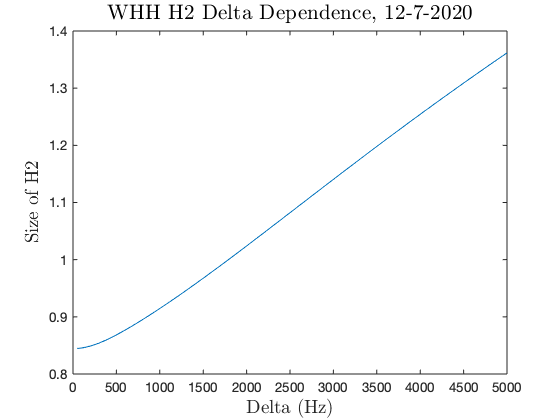

In [25]:
plot(deltas,results_h2(:,1))
%hold on
%plot(deltas,results_h4(:,1))
h=title('WHH H2 Delta Dependence, 12-7-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);
%legend('h2','h4')

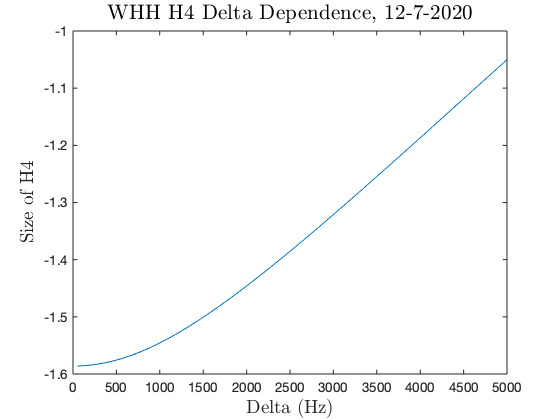

In [18]:
plot(deltas,results_h4(:,1))
h=title('WHH H4 Delta Dependence, 12-7-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H4');
set(h,'interpreter','latex','fontsize',14);

For the Tau experiment, 60 values of Tau between 0 and 20 microseconds were used.  Once again, only **h2** and **h4** are shown below.

In [14]:
sequenceName = 'WHH';  % select sequence to test over
testVarName = 'Tau'; % only affects file name currently
testValueCount = 60;
testValueMax = 20e-6;

In [15]:
% Configure Plots
tau_results = load('results01-18-21/TauWHH_Tau_magnus_results_18-Jan-2021.mat');
taus = tau_results.testVars;
results_h2 = tau_results.results_h2;
results_h4 = tau_results.results_h4;

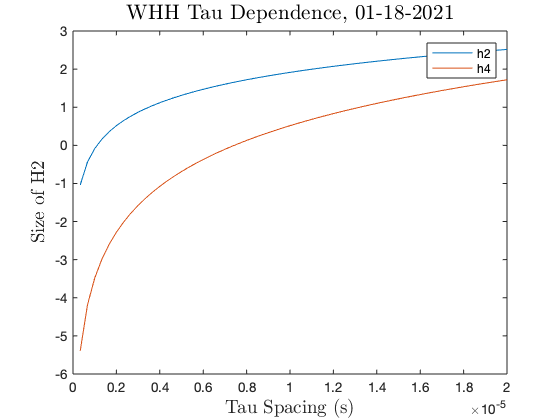

In [21]:
plot(taus,results_h2(:,1))
hold on
plot(taus,results_h4(:,1))
h=title('WHH Tau Dependence, 01-18-2021');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);
legend('h2','h4')

For the coupling experiment, 100 coupling strengths were tested up to a maximum coupling strength of 50 kHz.

In [23]:
% Configure Plots
couplings = load('results12-10-20/couplings_WHH_coupling_magnus_results_10-Dec-2020.mat').testVars;
results_h2 = load('results12-10-20/h2_WHH_coupling_magnus_results_10-Dec-2020.mat').results_h2;
results_h4 = load('results12-10-20/h4_WHH_coupling_magnus_results_10-Dec-2020.mat').results_h4;

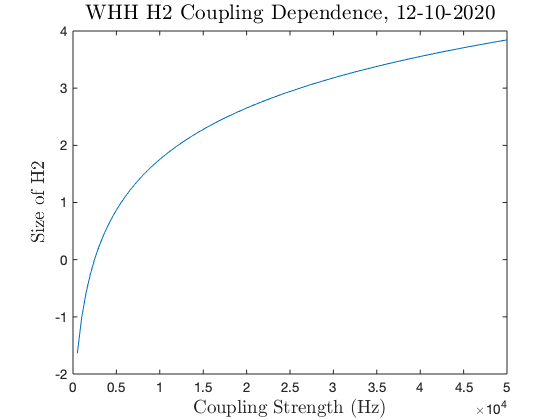

In [24]:
plot(couplings,results_h2(:,1))
h=title('WHH H2 Coupling Dependence, 12-10-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);

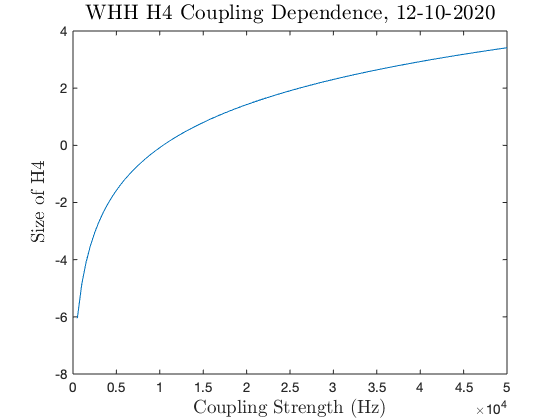

In [25]:
plot(couplings,results_h4(:,1))
h=title('WHH H4 Coupling Dependence, 12-10-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H4');
set(h,'interpreter','latex','fontsize',14);

Since there is some overlap between these two plots, they are shown below superimposed on each other.

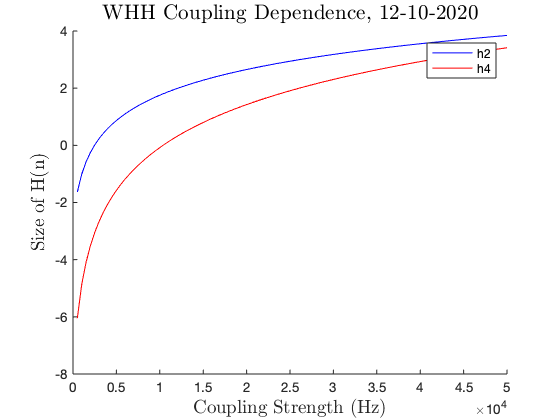

In [26]:
hold on
plot(couplings,results_h2(:,1),'blue')
plot(couplings,results_h4(:,1),'red')
hold off
h=title('WHH Coupling Dependence, 12-10-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);
legend('h2','h4')

### MREV-8

Unlike Wahuha, MREV-8 is not a symmetric pulse sequence, so all of the 2nd-5th terms are interesting to consider.  Plots of these terms follow, over the same parameter space as those above.

In [27]:
% Configure Plots
deltas = load('results12-10-20/Deltas_MREV8_Delta_magnus_results_10-Dec-2020.mat').testVars;
results_h1 = load('results12-10-20/h1_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h1;
results_h2 = load('results12-10-20/h2_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h2;
results_h3 = load('results12-10-20/h3_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h3;
results_h4 = load('results12-10-20/h4_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h4;

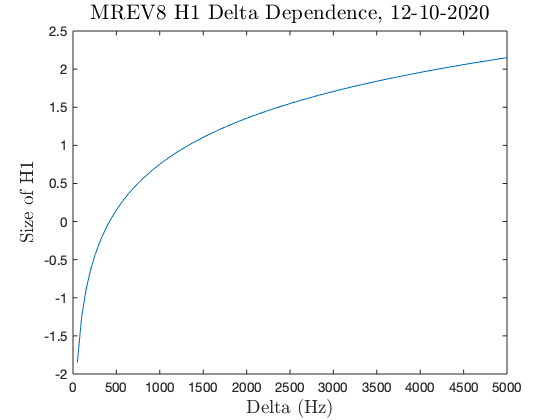

In [28]:
plot(deltas,results_h1(:,1))
h=title('MREV8 H1 Delta Dependence, 12-10-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H1');
set(h,'interpreter','latex','fontsize',14);

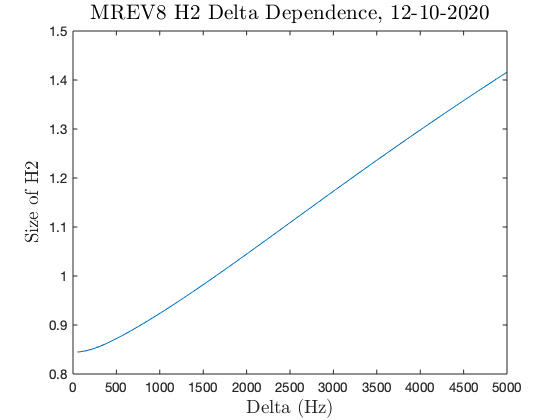

In [29]:
plot(deltas,results_h2(:,1))
h=title('MREV8 H2 Delta Dependence, 12-10-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);

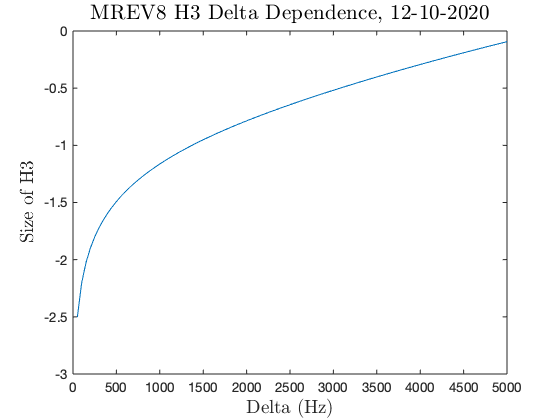

In [30]:
plot(deltas,results_h3(:,1))
h=title('MREV8 H3 Delta Dependence, 12-10-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H3');
set(h,'interpreter','latex','fontsize',14);

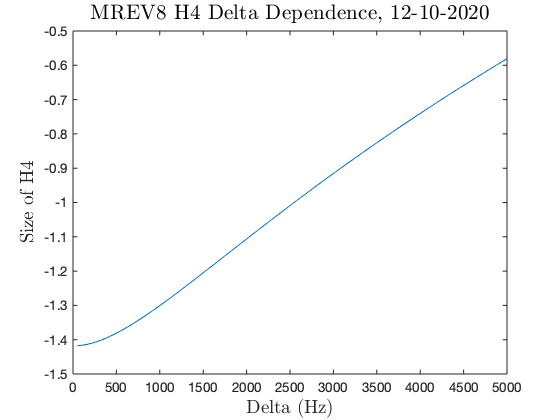

In [31]:
plot(deltas,results_h4(:,1))
h=title('MREV8 H4 Delta Dependence, 12-10-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H4');
set(h,'interpreter','latex','fontsize',14);

The four plots from above are overlayed below:

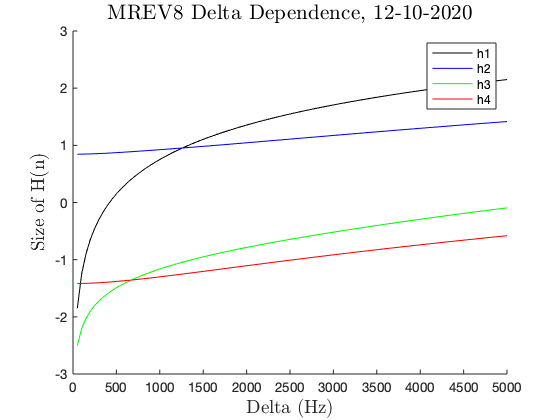

In [32]:
hold on
plot(deltas,results_h1(:,1),'black')
plot(deltas,results_h2(:,1),'blue')
plot(deltas,results_h3(:,1),'green')
plot(deltas,results_h4(:,1),'red')
h=title('MREV8 Delta Dependence, 12-10-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);
legend('h1', 'h2', 'h3', 'h4')

Plots of the MREV-8 terms and coupling strengths follow.  Interestingly, h1 seems to be relatively unaffected by the coupling strength.

In [33]:
% Configure Plots
couplings = load('results12-11-20/Couplings_MREV8_Coupling_magnus_results_11-Dec-2020.mat').testVars;
results_h1 = load('results12-11-20/h1_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h1;
results_h2 = load('results12-11-20/h2_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h2;
results_h3 = load('results12-11-20/h3_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h3;
results_h4 = load('results12-11-20/h4_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h4;

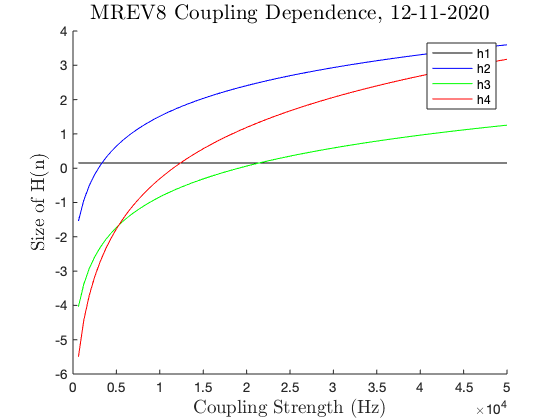

In [34]:
hold on
plot(couplings,results_h1(:,1),'black')
plot(couplings,results_h2(:,1),'blue')
plot(couplings,results_h3(:,1),'green')
plot(couplings,results_h4(:,1),'red')
h=title('MREV8 Coupling Dependence, 12-11-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);
legend('h1', 'h2', 'h3', 'h4')

The roughly flat magnitude of H1 most likely is a result of the chosen offset for this plot.  In the Delta plot we can see that $h1\approx 0$ so that might be the cause of this odd line here.

### Further Tests: December 11-

I noticed that the concavity in the Delta plots for WHH seemed to change, though it was difficult to tell.  To explore this further, I ran another WHH test over Delta, but increased the maximum value for Delta from 5 kHz to 20 kHz. It is very clear from the result plot that H2 does have a concavity change somewhere around $\Delta=5\text{ kHz}$.  Likewise H4 has a concavity change at around $\Delta=9\text{ kHz}$.

In [35]:
% Configure Plots
deltas = load('results12-11-20/Deltas_WHH_Delta_magnus_results_11-Dec-2020.mat').testVars;
results_h2 = load('results12-11-20/h2_WHH_Delta_magnus_results_11-Dec-2020.mat').results_h2;
results_h4 = load('results12-11-20/h4_WHH_Delta_magnus_results_11-Dec-2020.mat').results_h4;

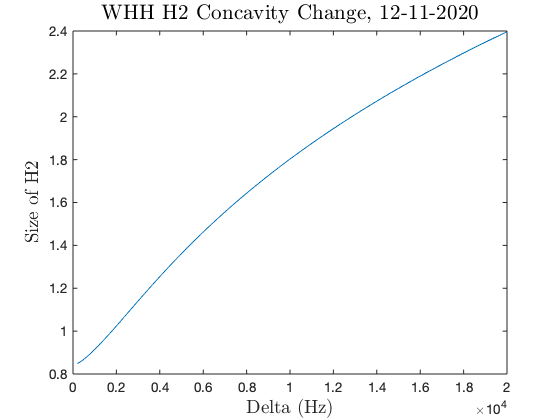

In [36]:
plot(deltas,results_h2(:,1))
h=title('WHH H2 Concavity Change, 12-11-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);

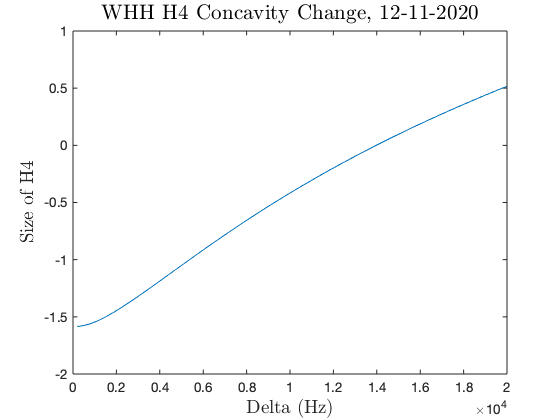

In [37]:
plot(deltas,results_h4(:,1))
h=title('WHH H4 Concavity Change, 12-11-2020');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H4');
set(h,'interpreter','latex','fontsize',14);

## Error Correlation

This code was then run for 30 values of both Delta and coupling to correspond with the grid over which earlier spin simulations of WHH-4 and MREV-8 were run.  The magnitude of h(n) for each delta-coupling pair was then plotted against the fidelity at that same delta-coupling pair for fixed values of pulse and tau.

My hope was to observe some negative correlation between fidelity (representing the error of the system) and the size of terms of the average Hamiltonian (a potential source of error).

### WAHUHA

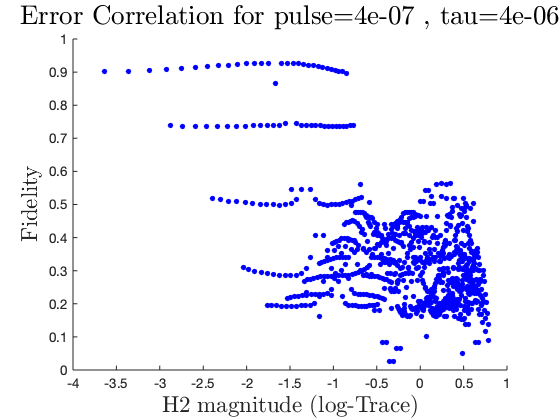

In [38]:
fidFile = 'Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-04-21/h2_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

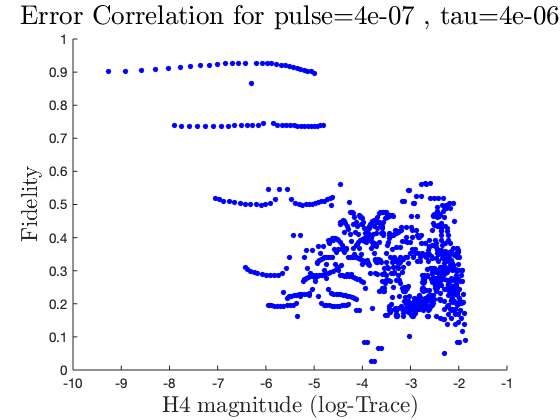

In [39]:
fidFile = 'Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-04-21/h4_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H4 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

For the above plots, note that the shapes are very similar but the x-axes differ as H4 is much smaller than H2.

For different values of pulse and tau, the plot continues to have a strange shape.

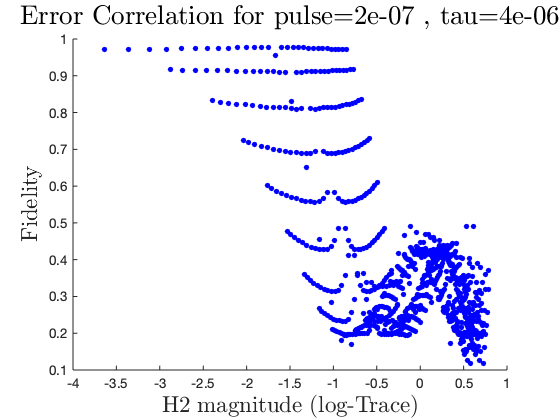

In [40]:
fidFile = 'Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-04-21/h2_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .2e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

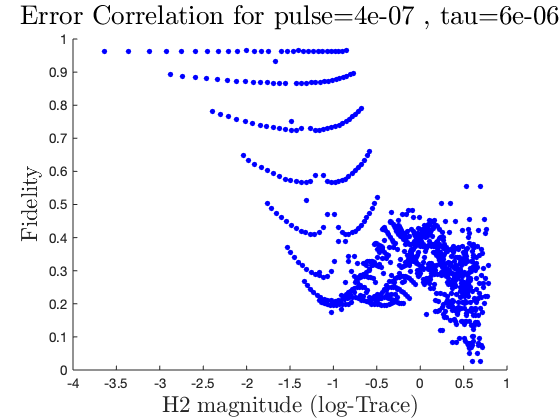

In [41]:
fidFile = 'Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-04-21/h2_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .4e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

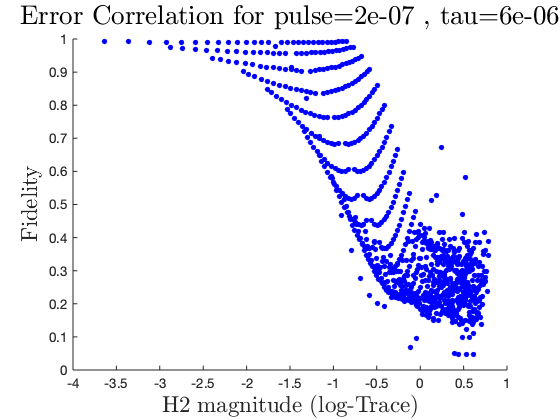

In [42]:
fidFile = 'Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-04-21/h2_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .2e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

**Does this mean we can conclude anything here? Fidelity definitely drops as H2 increases, and in this plot it seems more reasonable, but I wonder if there is something else interfering.**

Because of the more interesting pattern above, the error correlation for h4 and the same pulse-tau values is shown below.

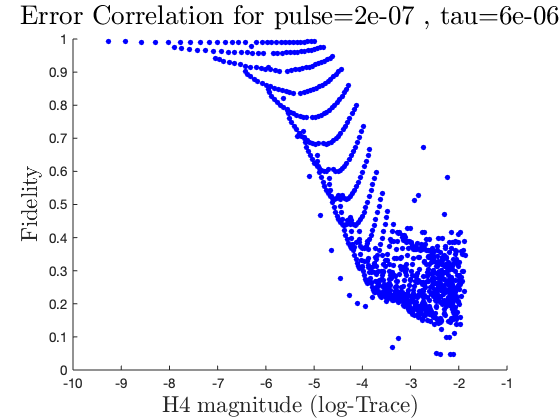

In [43]:
fidFile = 'Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-04-21/h4_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .2e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H4 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

### MREV-8

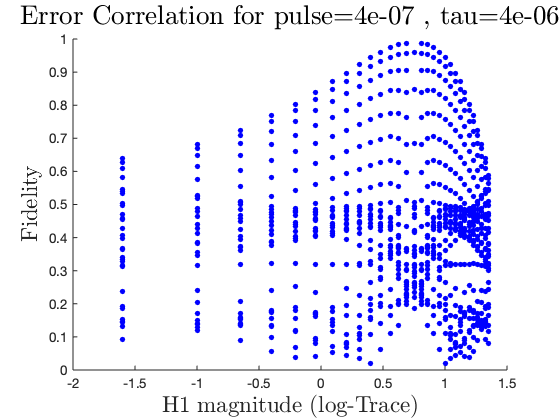

In [44]:
fidFile = 'Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-07-21/h1_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H1 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

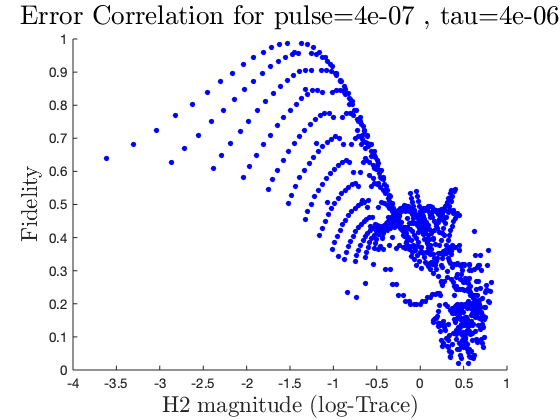

In [45]:
fidFile = 'Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-07-21/h2_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

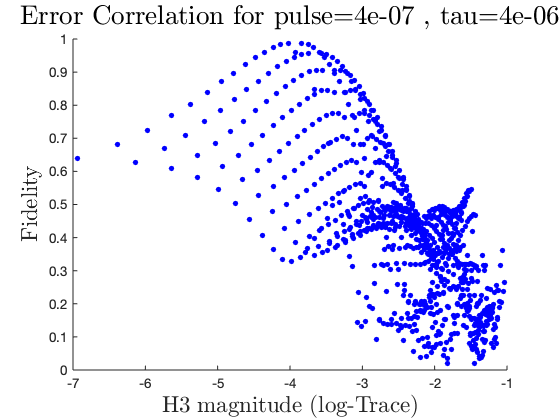

In [46]:
fidFile = 'Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-07-21/h3_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H3 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

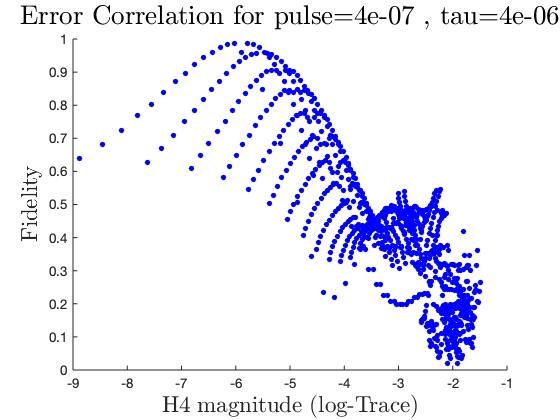

In [47]:
fidFile = 'Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-07-21/h4_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H4 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

Interestingly, for MREV-8, the terms H2 through H4 have a similar shape but H1 is markedly different.  This differs from the single-parameter plots where for delta, the odd terms had the same shape that differed from the even terms.

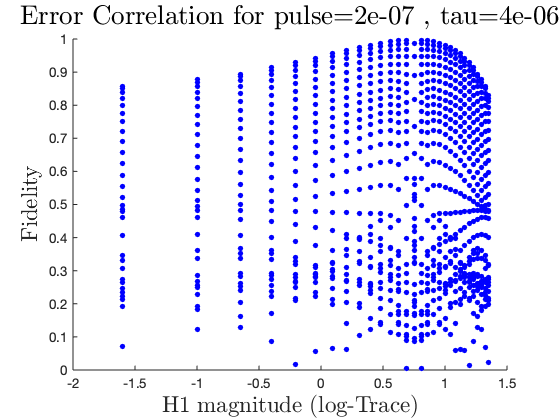

In [48]:
fidFile = 'Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-07-21/h1_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .2e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H1 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

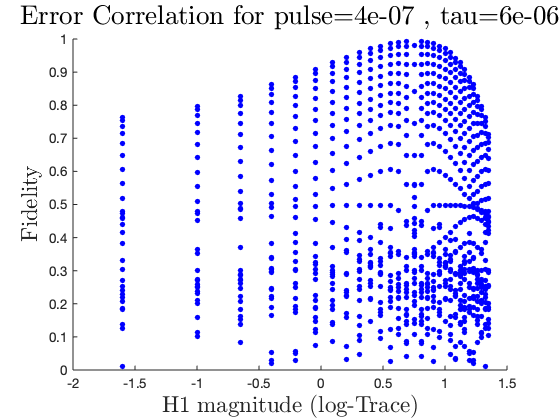

In [49]:
fidFile = 'Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-07-21/h1_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .4e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H1 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

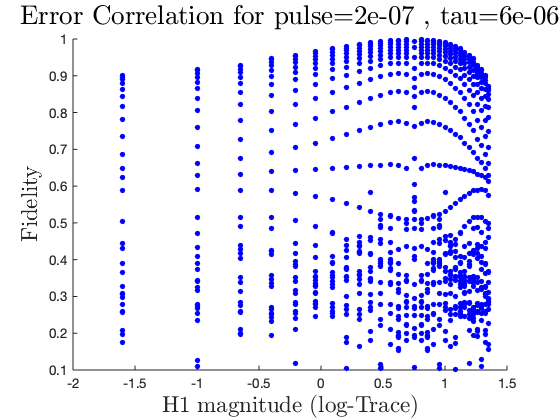

In [50]:
fidFile = 'Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-07-21/h1_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .2e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H1 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

The H1 plot retains its shape for various values of pulse and tau.

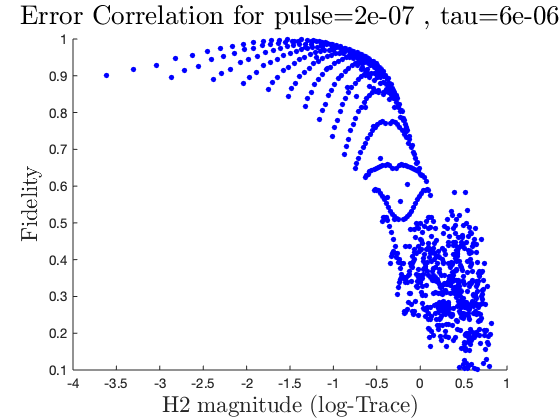

In [51]:
fidFile = 'Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results01-07-21/h2_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .2e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (log-Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

There is clearly no correlation between fidelity and the size of H1.  However H2 does seem to be a potential source of error for MREV-8?

## Some Thoughts For Now

In the original Spin Simulation I was running this summer, Fidelity measured the difference between evolving the system under $\bar H^{(0)}$ and a real pulse sequence with some $H(t)$.  Fidelity thus effectively measures how different $H$ is from $\bar H^{(0)}$. There are only two ways I can think of them to differ.  One is that the terms $\bar H^{(n)}$ for $n>0$ are large enough to cause a drop in fidelity.  The other is that the Magnus approximation ignores pulse duration.  Given how in the real experiment pulse length causes the greatest drop in Fidelity, I think it is most likely the latter that is the greatest source of error.

AN IDEA: Since I can numerically calculate at least the first few terms of the magnus expansion fairly easily, I can try evolving under WAHUHA and MREV8 using $\bar H^{(0)} +\bar H^{(1)}+ \bar H^{(2)}$ as my theoretical Hamiltonian.  Since for the most part $\bar H^{(3)}$ and higher order terms are very small compared to the earlier terms (and also very taxing to calculate) this should isolate error due to later order terms and only show fidelity based on other errors (most likely finite-pulse errors).